In [ ]:
# -------------------------------------------------------------------
# MNIST Digit Classification using K-Nearest Neighbors (KNN)
#
# Problem Statement:
# The MNIST dataset consists of grayscale images of handwritten digits 
# (0-9), each represented as a 28x28 pixel grid. The goal is to build a 
# K-Nearest Neighbors (KNN) classifier to identify the digit in each 
# image based on pixel intensity values. This involves preprocessing 
# the high-dimensional dataset, tuning hyperparameters, and evaluating 
# the model's accuracy on a test set.
#
# Objective:
# This notebook demonstrates the application of the KNN algorithm for 
# digit classification with a focus on preprocessing, feature selection, 
# and cross-validation to achieve robust performance.
#
# Workflow:
# 1. Preprocess the MNIST dataset:
#    - Normalize pixel intensity values using Min-Max Scaling.
#    - Remove low-variance features (<300 variance threshold) to reduce 
#      dimensionality and computational cost.
# 2. Perform hyperparameter tuning:
#    - Use GridSearchCV with 5-fold cross-validation to optimize 
#      hyperparameters (`n_neighbors`, `weights`, and `metric`).
# 3. Evaluate the final model:
#    - Test accuracy: 97.31%
#    - Precision, recall, and F1-scores exceed 0.97 for all classes.
#
# Links:
# - GitHub Repository: https://github.com/sashwattanay/MNIST-KNN-Classifier
#
# Repository Author: Sashwat Tanay
# -------------------------------------------------------------------

In [1]:
# Import necessary libraries
from sklearn.datasets import fetch_openml
import numpy as np

# Download the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# Inspect the keys of the fetched dataset to determine available attributes
print("Available keys in the dataset object:", mnist.keys())

# Dynamically extract the keywords for data and target
data_key = 'data' if 'data' in mnist.keys() else None
target_key = 'target' if 'target' in mnist.keys() else None

# Ensure the keys are found; otherwise, raise an error
if data_key is None or target_key is None:
    raise ValueError("The dataset does not contain expected 'data' or 'target' attributes.")

# Extract data (features) and target (labels) using the identified keys
X, y = mnist[data_key], mnist[target_key]

# Display the shape of the data and target
print(f"Shape of data (features): {X.shape}")
print(f"Shape of target (labels): {y.shape}")

# Convert target to integers if necessary (as it may initially be a string)
if y.dtype.kind == 'U':  # Check if target is a string type
    y = y.astype(int)

# Display the first few samples to confirm the data
print("First 5 labels:", y[:5])

Available keys in the dataset object: dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
Shape of data (features): (70000, 784)
Shape of target (labels): (70000,)
First 5 labels: ['5' '0' '4' '1' '9']


In [2]:
# Check the type of X and y
print("Type of X:", type(X))
print("Type of y:", type(y))

# Check the shape of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Check the number of dimensions (if they are NumPy arrays)
if isinstance(X, np.ndarray):
    print("Number of dimensions in X:", X.ndim)
    print("Data type of elements in X:", X.dtype)

if isinstance(y, np.ndarray):
    print("Number of dimensions in y:", y.ndim)
    print("Data type of elements in y:", y.dtype)

Type of X: <class 'numpy.ndarray'>
Type of y: <class 'numpy.ndarray'>
Shape of X: (70000, 784)
Shape of y: (70000,)
Number of dimensions in X: 2
Data type of elements in X: int64
Number of dimensions in y: 1
Data type of elements in y: object


In [3]:
y = y.astype(int)

In [4]:
print("Data type of y after conversion:", y.dtype)

Data type of y after conversion: int64


In [5]:
# Convert y to integers
y = y.astype(int)

# Re-check types and shapes
print("Type of X:", type(X))
print("Type of y:", type(y))
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Number of dimensions in X:", X.ndim)
print("Data type of elements in X:", X.dtype)
print("Number of dimensions in y:", y.ndim)
print("Data type of elements in y:", y.dtype)

Type of X: <class 'numpy.ndarray'>
Type of y: <class 'numpy.ndarray'>
Shape of X: (70000, 784)
Shape of y: (70000,)
Number of dimensions in X: 2
Data type of elements in X: int64
Number of dimensions in y: 1
Data type of elements in y: int64


In [6]:
print("First 5 labels:", y[:5])

First 5 labels: [5 0 4 1 9]


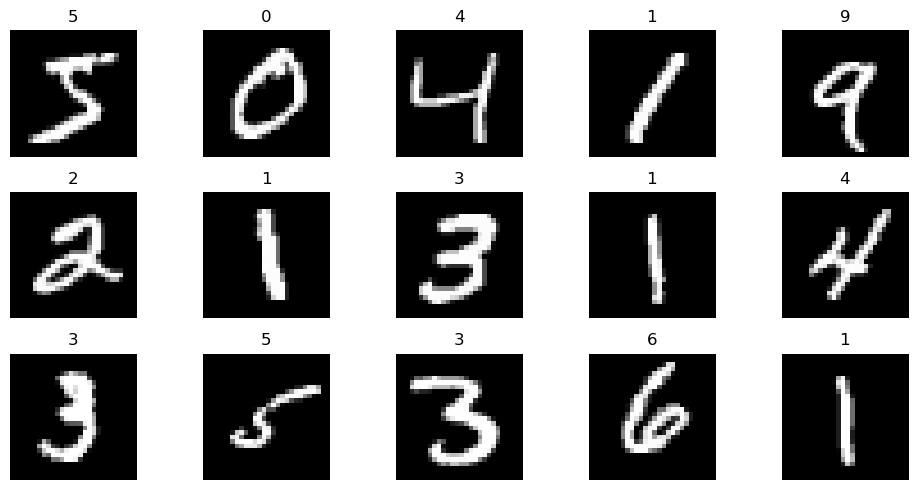

In [7]:
import matplotlib.pyplot as plt

# Function to display a grid of digit images
def plot_digits(data, labels, n_rows=3, n_cols=5):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5))
    axes = axes.ravel()  # Flatten the axes array for easier iteration
    for i in range(n_rows * n_cols):
        axes[i].imshow(data[i].reshape(28, 28), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(labels[i])
    plt.tight_layout()
    plt.show()

# Plot the first 15 digits from the dataset
plot_digits(X, y, n_rows=3, n_cols=5)

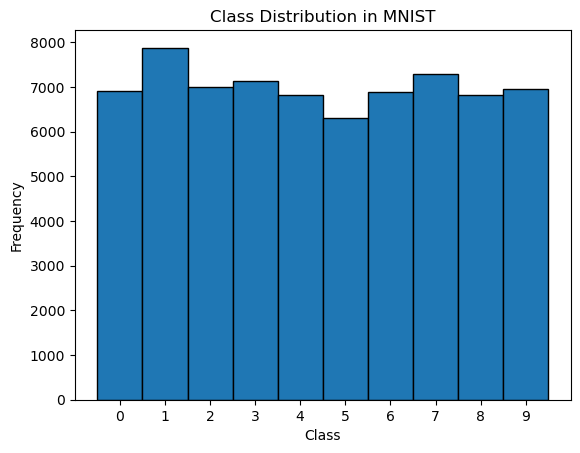

In [8]:
import matplotlib.pyplot as plt
plt.hist(y, bins=np.arange(11) - 0.5, edgecolor='black')
plt.xticks(range(10))
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Class Distribution in MNIST")
plt.show()

In [9]:
import numpy as np

variance = np.var(X, axis=0)  # Calculate variance for each feature (pixel)
zero_variance_features = np.where(variance == 0)[0]  # Index of zero-variance features
print(f"Number of zero-variance features: {len(zero_variance_features)}")

Number of zero-variance features: 65


In [10]:
low_variance_features = np.where(variance < 300)[0]
print(f"Number of near-zero variance features: {len(low_variance_features)}")

Number of near-zero variance features: 305


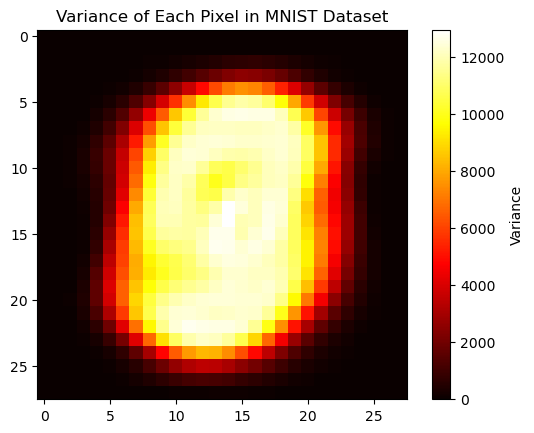

In [11]:
import matplotlib.pyplot as plt

variance_image = variance.reshape(28, 28)  # Reshape to 28x28 grid
plt.imshow(variance_image, cmap='hot', interpolation='nearest')
plt.colorbar(label="Variance")
plt.title("Variance of Each Pixel in MNIST Dataset")
plt.show()

In [12]:
# Drop low-variance features from the dataset
X_filtered = np.delete(X, low_variance_features, axis=1)

# Display the shape of the dataset before and after filtering
print(f"Shape of original dataset: {X.shape}")
print(f"Shape after removing low-variance features: {X_filtered.shape}")

Shape of original dataset: (70000, 784)
Shape after removing low-variance features: (70000, 479)


In [13]:
# Import MinMaxScaler from scikit-learn
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply Min-Max Scaling to the filtered MNIST features
X_scaled = scaler.fit_transform(X_filtered)

# Display the first few scaled samples to verify
print("First 5 scaled samples:")
print(X_scaled[:5])

First 5 scaled samples:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.57647059 0.98823529 0.16470588]]


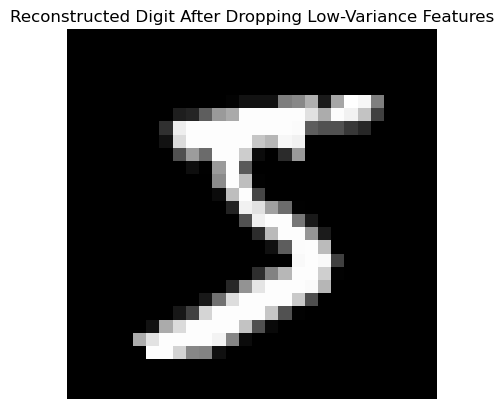

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Example: Select one sample from the scaled dataset
sample_idx = 0  # Index of the digit to plot
original_shape = (28, 28)  # Original grid shape (28x28 pixels)

# Step 1: Initialize a blank grid with zeros (to represent all 784 original features)
reconstructed_image = np.zeros(np.prod(original_shape))  # 784 elements

# Step 2: Map the retained features back to their original positions
remaining_features = np.delete(np.arange(784), low_variance_features)  # Indices of retained features
reconstructed_image[remaining_features] = X_scaled[sample_idx]  # Place scaled feature values

# Step 3: Reshape the 1D reconstructed image back to the original 28x28 grid
reconstructed_image = reconstructed_image.reshape(original_shape)

# Step 4: Plot the reconstructed image
plt.imshow(reconstructed_image, cmap='gray')
plt.title("Reconstructed Digit After Dropping Low-Variance Features")
plt.axis('off')
plt.show()

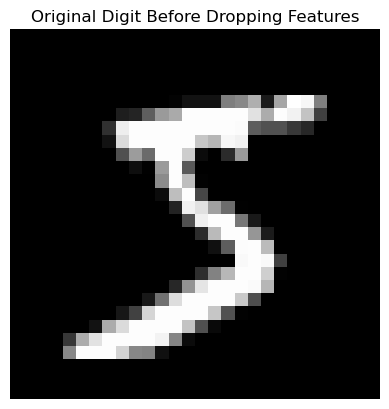

In [15]:
import matplotlib.pyplot as plt

# Example: Select the same sample index as used for reconstruction
sample_idx = 0  # Index of the digit to plot
original_shape = (28, 28)  # Original grid shape (28x28 pixels)

# Step 1: Reshape the original sample back to 28x28 grid
original_image = X[sample_idx].reshape(original_shape)

# Step 2: Plot the original image
plt.imshow(original_image, cmap='gray')
plt.title("Original Digit Before Dropping Features")
plt.axis('off')
plt.show()

In [16]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Display the shapes of the resulting datasets
print(f"Shape of training data: {X_train.shape}, Training labels: {y_train.shape}")
print(f"Shape of test data: {X_test.shape}, Test labels: {y_test.shape}")

Shape of training data: (56000, 479), Training labels: (56000,)
Shape of test data: (14000, 479), Test labels: (14000,)


In [ ]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import joblib

# Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Number of neighbors to test
    'weights': ['uniform', 'distance'],  # Weighting strategies
    'metric': ['euclidean', 'manhattan']  # Distance metrics
}

# Initialize the KNN model
knn = KNeighborsClassifier()

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Metric to optimize
    n_jobs=-1  # Use all available processors
)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and cross-validation score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Train the final model with the best hyperparameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Save the best model for later use
joblib.dump(best_model, "best_knn_model.pkl")
print("The best KNN model has been saved as 'best_knn_model.pkl'.")

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

# Load the saved model
best_model = joblib.load("best_knn_model.pkl")

# Use the model to make predictions on the test set
y_test_pred = best_model.predict(X_test)

# Evaluate the model's accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate a confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.9731
Confusion Matrix:
[[1375    1    1    0    0    0    3    0    0    1]
 [   0 1565    4    2    1    0    0    3    0    0]
 [  10   10 1345    4    2    0    4   19    4    0]
 [   1    1    6 1388    0   13    1    7    6    5]
 [   2   13    1    0 1307    0    5    2    0   35]
 [   5    3    1    6    1 1216   17    2    5    7]
 [   5    5    0    0    2    5 1357    0    1    0]
 [   1   13    3    0    1    0    0 1429    0   12]
 [   7    8    0   17    2   20    4    3 1293   11]
 [   1    5    0    6   12    2    0   15    2 1348]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1381
           1       0.96      0.99      0.98      1575
           2       0.99      0.96      0.97      1398
           3       0.98      0.97      0.97      1428
           4       0.98      0.96      0.97      1365
           5       0.97      0.96      0.97      1263
           6       0.98    